In [1]:
from helper.trajectory import Trajectory
from models.stonesoup_radar_sim import StonesoupRadarSim
import numpy as np
import pickle
import os
import torch
import matplotlib.pyplot as plt
from models.bnkf import BNKF
from helper.evaluator import Evaluator
import time

In [2]:
traj_no = 1250
_sensor_noise_level = "high"
_remove_prct = 25

In [3]:
with open("../../dataset/dataframe-readins/full_traj_data.pkl", "rb") as f:
    test_traj_data = pickle.load(f)

## EKF Pred

In [4]:
def run_stonesoup_ekf_eval_pipeline(aTrajectory, aSim, anEvaluator, ifplot=False, ifshow=False, moe=False):
    test_radar_meas = aSim.simulate_radar_measurements(aTrajectory)
    filter_tracks_list = aSim.run_ekf_filter(aTrajectory, test_radar_meas)
    
    converted_state_vecs, measurement_conversion_data = aSim.convert_radar_observations_to_cartesian(test_radar_meas)
    aTrajectory.set_converted_measurement_data(measurement_conversion_data)

    predicted_state_data, predicted_uncer_std_data = aSim.process_stonesoup_tracker_info(filter_tracks_list)
    full_pos_states, full_pos_covs = aSim.gather_position_prediction_info(filter_tracks_list) # for numerical eval
    
    if ifplot:
        #aTrajectory.visualize_truth_versus_measurement()
        #aTrajectory.visualize_truth_versus_filter(predicted_state_data, predicted_uncer_std_data)
        aTrajectory.visualize_truth_versus_filter_line_bounds(predicted_state_data, predicted_uncer_std_data, 2)
        
    outData = {}
    if moe:
        full_truth_pos = np.column_stack((aTrajectory.truth_x[1:], aTrajectory.truth_y[1:], aTrajectory.truth_z[1:]))
        outData['PredErrAvg'] = anEvaluator.calculate_3d_avg_euclid_error(aTrajectory.truth_x[1:], aTrajectory.truth_y[1:], aTrajectory.truth_z[1:], predicted_state_data['x'], predicted_state_data['y'], predicted_state_data['z'])
    else:
        full_truth_pos = np.column_stack((aTrajectory.orig_truth_x[1:], aTrajectory.orig_truth_y[1:], aTrajectory.orig_truth_z[1:]))
        outData['PredErrAvg'] = anEvaluator.calculate_3d_avg_euclid_error(aTrajectory.orig_truth_x[1:], aTrajectory.orig_truth_y[1:], aTrajectory.orig_truth_z[1:], predicted_state_data['x'],predicted_state_data['y'], predicted_state_data['z'])
    
    full_meas_pos = np.column_stack((measurement_conversion_data['x'][1:], measurement_conversion_data['y'][1:], measurement_conversion_data['z'][1:]))
    
    outData['MeasErrAvg'] = anEvaluator.calculate_3d_avg_euclid_error(aTrajectory.truth_x[1:], aTrajectory.truth_y[1:], aTrajectory.truth_z[1:], measurement_conversion_data['x'][1:], measurement_conversion_data['y'][1:], measurement_conversion_data['z'][1:])
    
    # outData['MeasMDAvg'] = anEvaluator.average_mahalanobis_distance(full_meas_pos, full_pos_covs, full_truth_pos)
    # 
    # outData['MeasDeterminantAvg'] = anEvaluator.compute_average_determinant(full_pos_covs)
    
    outData['MDAvg'] = anEvaluator.average_mahalanobis_distance(full_pos_states, full_pos_covs, full_truth_pos)
    outData['DeterminantAvg'] = anEvaluator.compute_average_determinant(full_pos_covs)
    outData['TraceAvg'] = anEvaluator.compute_average_covariance_trace(full_pos_covs)
    
    if ifshow:
        print(f"Average Filter Error: {outData['PredErrAvg']}")
        print(f"Average Measurement Error: {outData['MeasErrAvg']}")
        print(f"Average Filter Trace: {outData['TraceAvg']}")
        print(f"Average Filter MD: {outData['MDAvg']}")
        print(f"Average Filter Determinant: {outData['DeterminantAvg']}")
    return outData, aTrajectory, full_pos_states, full_pos_covs

In [5]:
def run_stonesoup_ukf_eval_pipeline(aTrajectory, aSim, anEvaluator, ifplot=False, ifshow=False, moe=False):
    test_radar_meas = aSim.simulate_radar_measurements(aTrajectory)
    filter_tracks_list = aSim.run_ukf_filter(aTrajectory, test_radar_meas)
    
    converted_state_vecs, measurement_conversion_data = aSim.convert_radar_observations_to_cartesian(test_radar_meas)
    aTrajectory.set_converted_measurement_data(measurement_conversion_data)

    predicted_state_data, predicted_uncer_std_data = aSim.process_stonesoup_tracker_info(filter_tracks_list)
    full_pos_states, full_pos_covs = aSim.gather_position_prediction_info(filter_tracks_list) # for numerical eval
    
    if ifplot:
        #aTrajectory.visualize_truth_versus_measurement()
        #aTrajectory.visualize_truth_versus_filter(predicted_state_data, predicted_uncer_std_data)
        aTrajectory.visualize_truth_versus_filter_line_bounds(predicted_state_data, predicted_uncer_std_data, 2)
        
    outData = {}
    if moe:
        full_truth_pos = np.column_stack((aTrajectory.truth_x[1:], aTrajectory.truth_y[1:], aTrajectory.truth_z[1:]))
        outData['PredErrAvg'] = anEvaluator.calculate_3d_avg_euclid_error(aTrajectory.truth_x[1:], aTrajectory.truth_y[1:], aTrajectory.truth_z[1:], predicted_state_data['x'], predicted_state_data['y'], predicted_state_data['z'])
    else:
        full_truth_pos = np.column_stack((aTrajectory.orig_truth_x[1:], aTrajectory.orig_truth_y[1:], aTrajectory.orig_truth_z[1:]))
        outData['PredErrAvg'] = anEvaluator.calculate_3d_avg_euclid_error(aTrajectory.orig_truth_x[1:], aTrajectory.orig_truth_y[1:], aTrajectory.orig_truth_z[1:], predicted_state_data['x'],predicted_state_data['y'], predicted_state_data['z'])
    
    full_meas_pos = np.column_stack((measurement_conversion_data['x'][1:], measurement_conversion_data['y'][1:], measurement_conversion_data['z'][1:]))
    
    outData['MeasErrAvg'] = anEvaluator.calculate_3d_avg_euclid_error(aTrajectory.truth_x[1:], aTrajectory.truth_y[1:], aTrajectory.truth_z[1:], measurement_conversion_data['x'][1:], measurement_conversion_data['y'][1:], measurement_conversion_data['z'][1:])
    
    # outData['MeasMDAvg'] = anEvaluator.average_mahalanobis_distance(full_meas_pos, full_pos_covs, full_truth_pos)
    # 
    # outData['MeasDeterminantAvg'] = anEvaluator.compute_average_determinant(full_pos_covs)
    
    outData['MDAvg'] = anEvaluator.average_mahalanobis_distance(full_pos_states, full_pos_covs, full_truth_pos)
    outData['DeterminantAvg'] = anEvaluator.compute_average_determinant(full_pos_covs)
    outData['TraceAvg'] = anEvaluator.compute_average_covariance_trace(full_pos_covs)
    
    if ifshow:
        print(f"Average Filter Error: {outData['PredErrAvg']}")
        print(f"Average Measurement Error: {outData['MeasErrAvg']}")
        print(f"Average Filter Trace: {outData['TraceAvg']}")
        print(f"Average Filter MD: {outData['MDAvg']}")
        print(f"Average Filter Determinant: {outData['DeterminantAvg']}")
    return outData, aTrajectory, full_pos_states, full_pos_covs

In [6]:
def store_truth_data(aDF):
    truth_data = {}
    truth_data['timestamps'] = np.array(aDF['timestamp'])
    truth_data['x'] = np.array(aDF['tx'])
    truth_data['y'] = np.array(aDF['ty'])
    truth_data['z'] = np.array(aDF['tz'])
    truth_data['vx'] = np.array(aDF['vx'])
    truth_data['vy'] = np.array(aDF['vy'])
    truth_data['vz'] = np.array(aDF['vz'])
    return truth_data

In [27]:
# Measurement Simulation Inputs
moe = True 
test_traj_df = test_traj_data[traj_no]
display(test_traj_df)
truth_data = store_truth_data(test_traj_df)

,timestamp,tx,ty,tz,vx,vy,vz,delta_time
0,0.000000,15.374643,25.861643,5.906171,1.116548,1.228383,-0.382918,0.100000
1,0.100000,15.486298,25.984481,5.867880,1.141110,1.183026,-0.224051,0.100000
2,0.200000,15.600409,26.102783,5.845475,1.427731,1.038539,0.028048,0.100000
3,0.300000,15.743182,26.206637,5.848279,2.319777,1.086622,0.070664,0.100000
4,0.400000,15.975159,26.315299,5.855346,2.945092,0.948561,0.017373,0.100000
...,...,...,...,...,...,...,...,...
115,11.499989,21.114380,33.484630,5.628151,-3.489869,1.645451,0.152129,0.100000
116,11.599989,20.765392,33.649176,5.643364,-3.595454,1.377408,0.127266,0.100000
117,11.699989,20.405845,33.786917,5.656090,-3.704440,1.073601,0.168591,0.099999
118,11.799989,20.035403,33.894277,5.672949,-3.823178,0.782567,0.115706,0.099999


In [28]:
print(len(test_traj_data))

5093


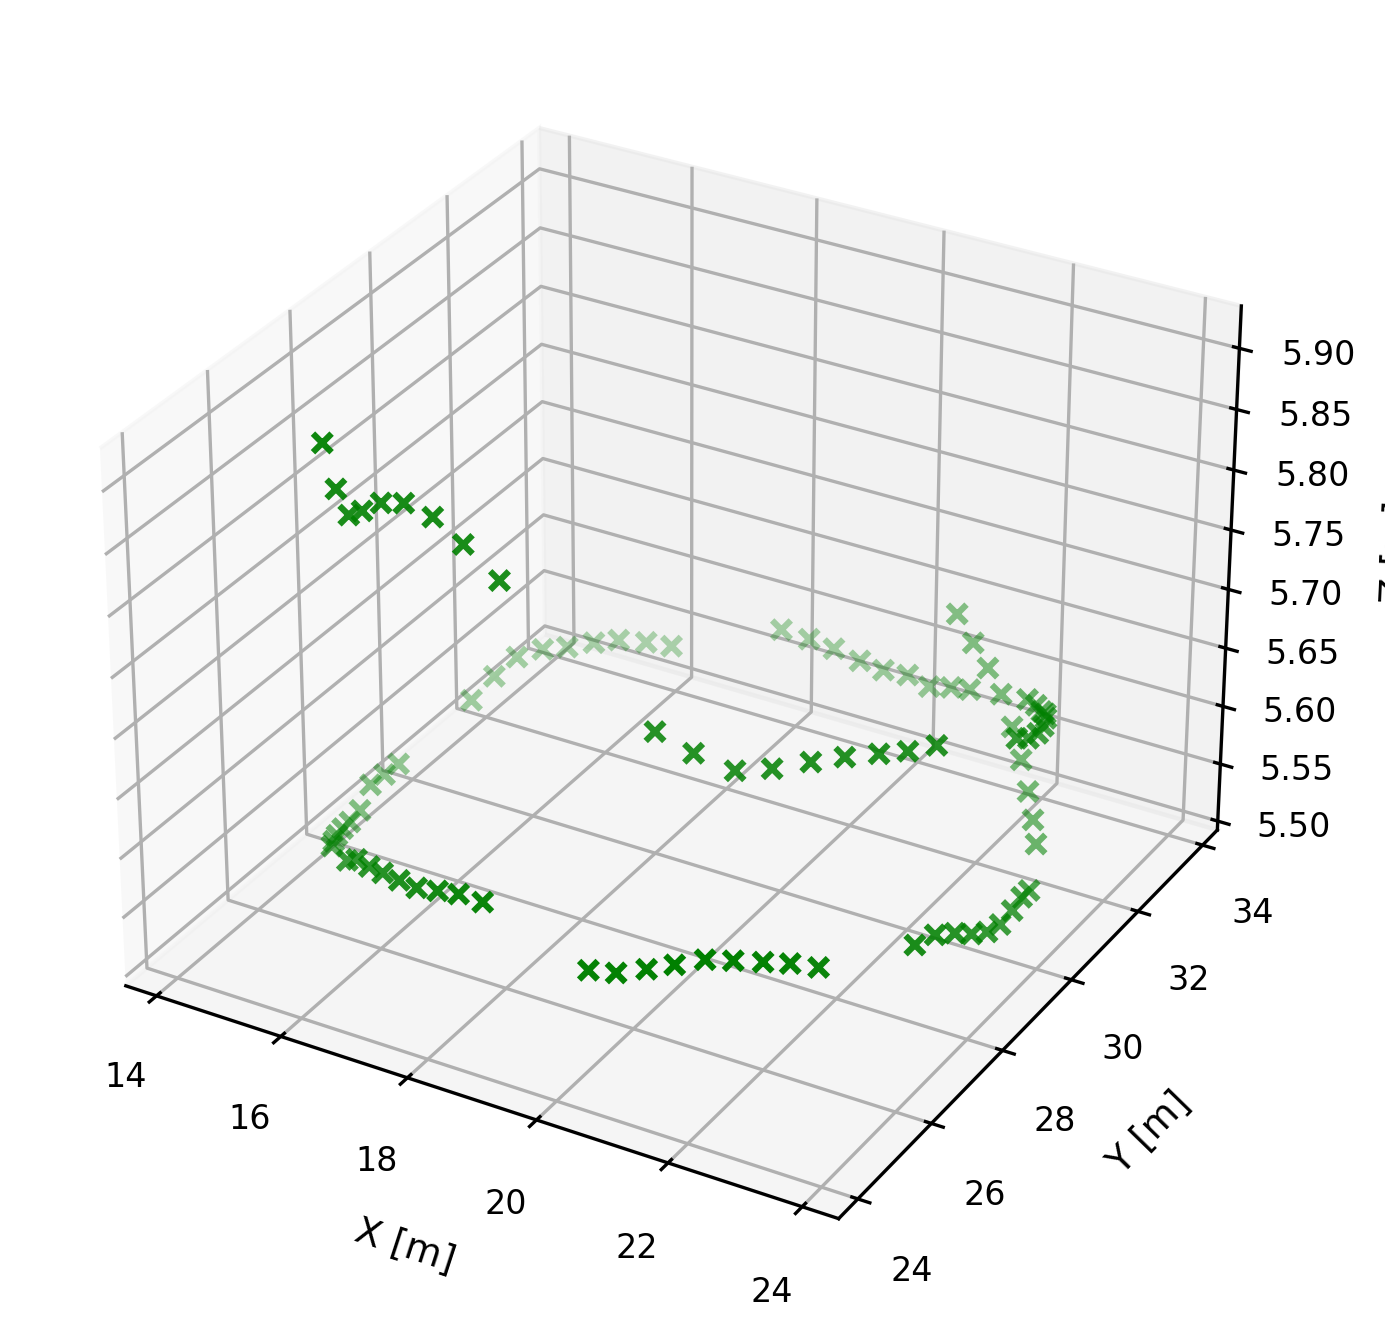

CPU times: total: 93.8 ms
Wall time: 274 ms


In [29]:
%%time
TestTraj = Trajectory(truth_data, 1, measurement_only_eval=moe)
TestTraj.apply_sampling_gaps(remove_pct=_remove_prct)
TestSim = StonesoupRadarSim(proc_noise=0.1, sensor_noise_level=_sensor_noise_level, include_range_rate=True)
TestEval = Evaluator()
TestTraj.visualize_3d_scatter()

In [87]:
start = time.time()
out_ekf, altered_traj_ekf, full_ekf_pos_states, full_ekf_pos_covs = run_stonesoup_ekf_eval_pipeline(TestTraj, TestSim, TestEval, ifplot=False, ifshow=True, moe=moe)
elapsed_ekf_time = time.time() - start

Average Filter Error: 49.56638753491368
Average Measurement Error: 74.8899333590637
Average Filter Trace: 99.79076493174267
Average Filter MD: 10.538159306219857
Average Filter Determinant: 520.5847300125586


In [93]:
%%time
start = time.time()
out_ukf, altered_traj_ukf, full_ukf_pos_states, full_ukf_pos_covs = run_stonesoup_ukf_eval_pipeline(TestTraj, TestSim, TestEval, ifplot=False, ifshow=True, moe=moe)
elapsed_ukf_time = time.time() - start

C:\Users\guptaa2\Anaconda\envs\PINNSFP\Lib\site-packages\stonesoup\functions\__init__.py:225: UserWarning: LinAlgError('Matrix is not positive definite')
  warnings.warn(repr(e))


Average Filter Error: 54.993619459045576
Average Measurement Error: 93.38662297062533
Average Filter Trace: 308.94361560773217
Average Filter MD: 9.32349625345326
Average Filter Determinant: 1918.9929798413787
CPU times: total: 359 ms
Wall time: 562 ms


In [112]:
x_ekf_pred = np.array([item[0] for item in full_ekf_pos_states])
y_ekf_pred = np.array([item[1] for item in full_ekf_pos_states])
z_ekf_pred = np.array([item[2] for item in full_ekf_pos_states])

In [113]:
x_ekf_std = np.array([np.sqrt(item[0][0]) for item in full_ekf_pos_covs])
y_ekf_std = np.array([np.sqrt(item[1][1]) for item in full_ekf_pos_covs])
z_ekf_std = np.array([np.sqrt(item[2][2]) for item in full_ekf_pos_covs])

In [114]:
x_ukf_pred = np.array([item[0] for item in full_ukf_pos_states])
y_ukf_pred = np.array([item[1] for item in full_ukf_pos_states])
z_ukf_pred = np.array([item[2] for item in full_ukf_pos_states])

In [115]:
x_ukf_std = np.array([np.sqrt(item[0][0]) for item in full_ukf_pos_covs])
y_ukf_std = np.array([np.sqrt(item[1][1]) for item in full_ukf_pos_covs])
z_ukf_std = np.array([np.sqrt(item[2][2]) for item in full_ukf_pos_covs])

## BNKF Pred

In [116]:
aug_path_in = f"../../dataset/dataframe-readins/cv/augmented/full_traj_data_proc_noise_{_sensor_noise_level}.pkl"

if os.path.exists(aug_path_in):
    with open(aug_path_in, "rb") as e:
        aug_proc_traj_data = pickle.load(e)

In [117]:
# training params
incl_rr = True

X_columns = ["measured_x", "measured_y", "measured_z", "measured_vx", "measured_vy", "measured_vz",
             "measured_plus_x", "measured_plus_y", "measured_plus_z", "measured_plus_vx", "measured_plus_vy", "measured_plus_vz", "sigma_range", "sigma_range_rate", "sigma_elevation", "sigma_bearing", "delta_time"]

y_columns = ["truth_x", "truth_y", "truth_z", "truth_vx", "truth_vy", "truth_vz"]

In [118]:
def return_index_cv_params(full_proc_traj_data_in, test_traj):
    train_X_mats = []
    train_y_vecs = []
    test_X_mats = []
    test_y_vecs = []
    
    physics_metadata_train_dicts = []
    physics_metadata_test_dicts = []
    
    data_len = len(full_proc_traj_data_in)
    split_idx = int(0.8 * data_len)
    first_80_indices = np.arange(0, split_idx)
    last_20_indices = np.arange(split_idx, data_len)

    cv_indices = [(first_80_indices, last_20_indices)]
    for index in cv_indices:
    
        train_pmd_dict = {
            'inputPos': torch.cat([full_proc_traj_data_in[key]['physics_meta_data']['inputPos'] for key in index[0]], dim=0),
            'inputVel': torch.cat([full_proc_traj_data_in[key]['physics_meta_data']['inputVel'] for key in index[0]], dim=0),
            'inputObs': torch.cat([full_proc_traj_data_in[key]['physics_meta_data']['inputObs'] for key in index[0]], dim=0),
            'inputRngErr': torch.cat([full_proc_traj_data_in[key]['physics_meta_data']['inputRngErr'] for key in index[0]], dim=0),
            'dtVec': torch.cat([full_proc_traj_data_in[key]['physics_meta_data']['dtVec'] for key in index[0]], dim=0)}
        
        train_X_mats.append(torch.cat([full_proc_traj_data_in[key]['X_mat'] for key in index[0]], dim=0))
        train_y_vecs.append(torch.cat([full_proc_traj_data_in[key]['y_vec'] for key in index[0]], dim=0))
        physics_metadata_train_dicts.append(train_pmd_dict)
        
        test_pmd_dict = {
            'inputPos': full_proc_traj_data_in[test_traj]['physics_meta_data']['inputPos'],
            'inputVel': full_proc_traj_data_in[test_traj]['physics_meta_data']['inputVel'],
            'inputObs': full_proc_traj_data_in[test_traj]['physics_meta_data']['inputObs'],
            'inputRngErr': full_proc_traj_data_in[test_traj]['physics_meta_data']['inputRngErr'],
            'dtVec': full_proc_traj_data_in[test_traj]['physics_meta_data']['dtVec']}
        
        test_X_mats.append(full_proc_traj_data_in[test_traj]['X_mat'])
        test_y_vecs.append(full_proc_traj_data_in[test_traj]['y_vec'])
        physics_metadata_test_dicts.append(test_pmd_dict)
        
    return train_X_mats, train_y_vecs, test_X_mats, test_y_vecs, physics_metadata_train_dicts, physics_metadata_test_dicts

In [119]:
o_train_X_mats, o_train_y_vecs, o_test_X_mats, o_test_y_vecs, o_physics_metadata_train_dicts, o_physics_metadata_test_dicts= return_index_cv_params(aug_proc_traj_data, traj_no)

In [120]:
X_mat_in = o_train_X_mats[0]
y_vec_in = o_train_y_vecs[0]
physics_metadata = o_physics_metadata_train_dicts[0]
lambda_params_in = {'ml': 1, 'physics': 0}
load_weight = True

In [121]:
%%time

bnkf_model = BNKF(input_size=X_mat_in.shape[1], output_size=y_vec_in.shape[1], hidden_layer_size=64, sensor_noise_level=_sensor_noise_level,
                 prior_sigma_lay=0.01, lambda_params=lambda_params_in, epochs=1000, bias_in=True)
if load_weight:
    bnkf_model.load_model_weights('BNKF_pibnn_model_2025-05-17_14-46-17.pth')
else:
    bnkf_model.fit(X_mat_in, y_vec_in, physics_metadata)
    bnkf_model.plot()
    print(f"FINAL LOSS: {bnkf_model.loss_values[-1]}")
    bnkf_model.save_model_weights("BNKF")

Model weights loaded from BNKF_pibnn_model_2025-05-17_14-46-17.pth
CPU times: total: 0 ns
Wall time: 9 ms


C:\Users\guptaa2\Documents\JHUEP\Bayesian_Neural_Kalman_Filtering\models\bnkf.py:164: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(filepath)

In [122]:
X_mat_test = o_test_X_mats[0][120:210, :]
y_vec_test = o_test_y_vecs[0][120:210, :]
physics_metadata_test = {'inputPos': o_physics_metadata_test_dicts[0]['inputPos'][120:210, :],
                         'inputVel': o_physics_metadata_test_dicts[0]['inputVel'][120:210, :],
                         'inputObs': o_physics_metadata_test_dicts[0]['inputObs'][120:210, :],
                         'inputRngErr': o_physics_metadata_test_dicts[0]['inputRngErr'][120:210, :],
                         'dtVec': o_physics_metadata_test_dicts[0]['dtVec'][120:210, :]
                         }

In [123]:
start = time.time()
nn_state_est_vecs, nn_state_est_covs = bnkf_model.predict(X_mat_test, physics_metadata_test, apply_filter_update=True)
elapsed_bnkf_time = time.time() - start

In [124]:
print(X_mat_test.shape)
print(y_vec_test.shape)
print(physics_metadata_test['inputObs'][120:210, :].shape)
print(physics_metadata_test['inputRngErr'][120:210, :].shape)

torch.Size([90, 17])
torch.Size([90, 6])
torch.Size([0, 6])
torch.Size([0, 1])


In [125]:
print(nn_state_est_vecs.shape)
print(nn_state_est_covs.shape)

(90, 6)
(90, 6, 6)


### Plotting

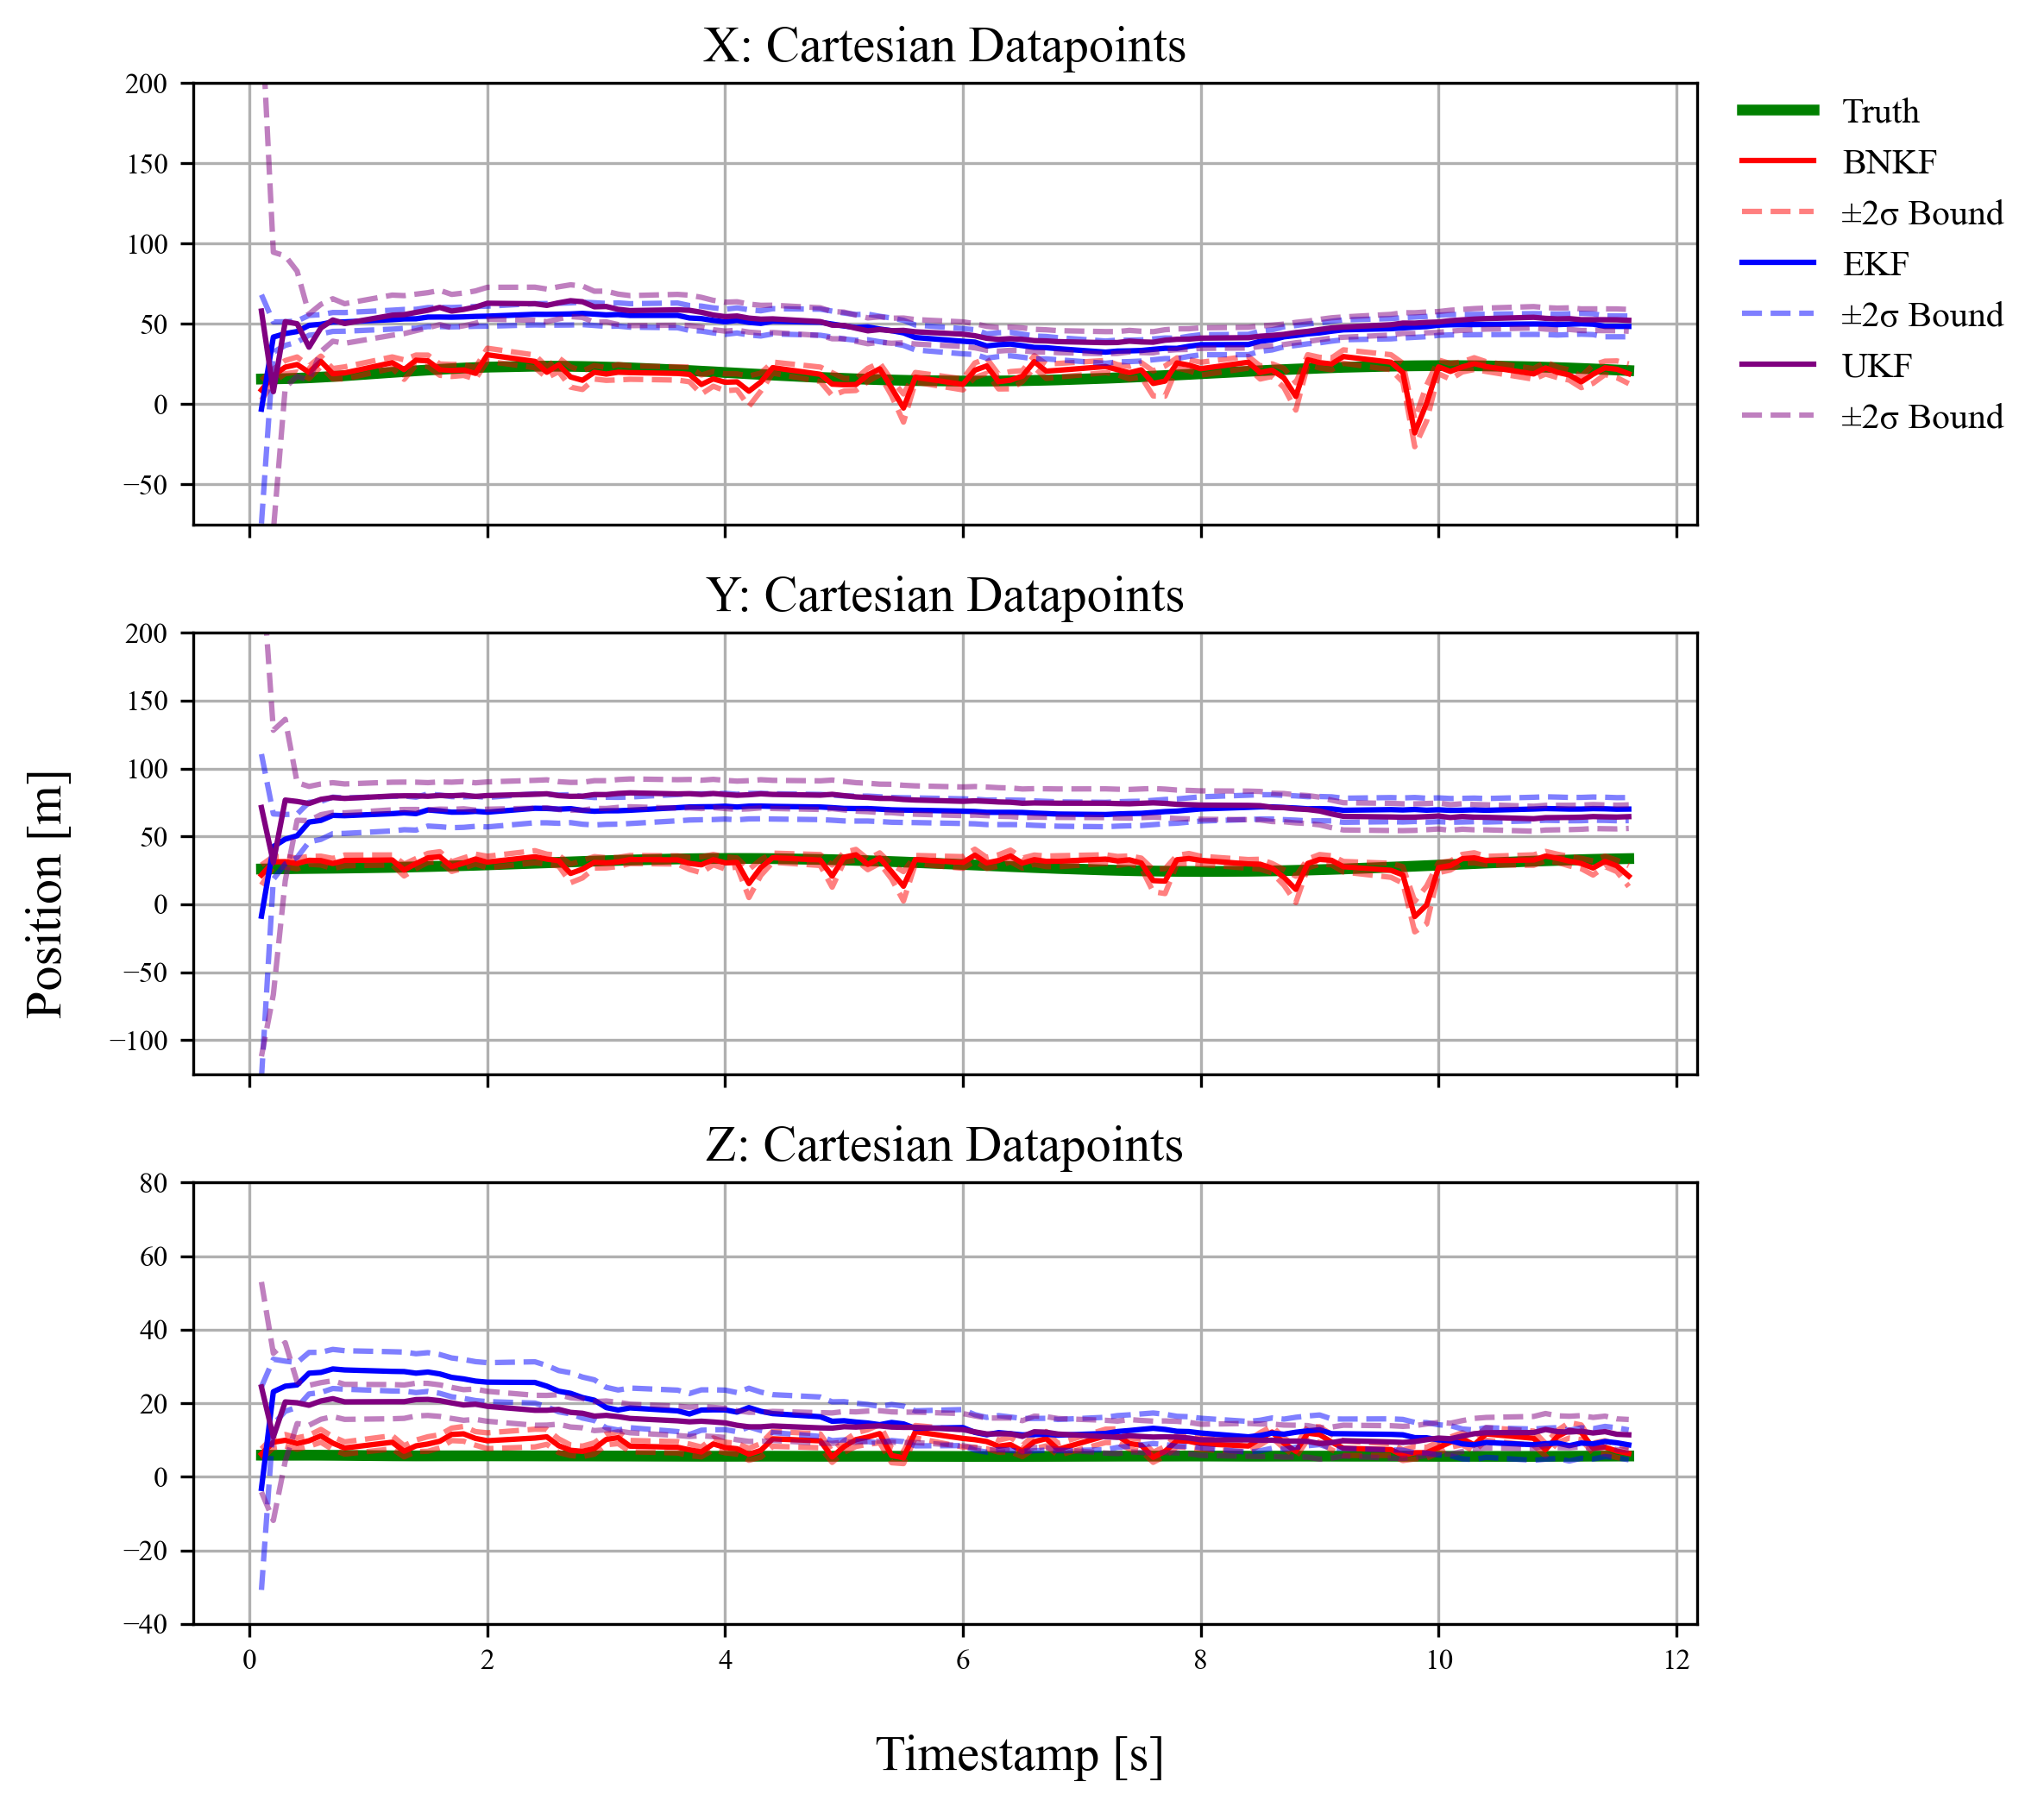

In [141]:
# ---- Sizes tuned for IEEE double-column ----
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({
    "font.size": 10,          # base font
    "axes.titlesize": 14,    # subplot titles
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 10,
    "lines.linewidth": 1.5,  # slightly thicker for print
    "figure.dpi": 300,       # crisp export
})

# Make a bit of room on the right for the outside legend
fig, axes = plt.subplots(3, 1, figsize=(8.0, 7.0), sharex=True)  # ~\textwidth

# --- your plotting code stays exactly the same below this line ---
# Extract truth components
x_vals = y_vec_test[:, 0].numpy()
y_vals = y_vec_test[:, 1].numpy()
z_vals = y_vec_test[:, 2].numpy()

# Extract prediction components
x_pred = nn_state_est_vecs[:, 0]
y_pred = nn_state_est_vecs[:, 1]
z_pred = nn_state_est_vecs[:, 2]

x_std = np.sqrt(nn_state_est_covs[:, 0, 0])
y_std = np.sqrt(nn_state_est_covs[:, 1, 1])
z_std = np.sqrt(nn_state_est_covs[:, 2, 2])

time_values = TestTraj.truth_time_data[1:]

# Plot X
axes[0].plot(time_values, x_vals[1:], label='Truth', color='green', linewidth=3)

axes[0].plot(time_values, x_pred[1:], label='BNKF', color='red')
axes[0].plot(time_values, x_pred[1:] + 2*x_std[1:], linestyle='--', color='r', alpha=0.5, label=f"±2σ Bound")
axes[0].plot(time_values, x_pred[1:] - 2*x_std[1:], linestyle='--', color='r', alpha=0.5)

axes[0].plot(time_values, x_ekf_pred, label='EKF', color='blue')
axes[0].plot(time_values, x_ekf_pred + 2*x_ekf_std, linestyle='--', color='blue', alpha=0.5, label=f"±2σ Bound")
axes[0].plot(time_values, x_ekf_pred - 2*x_ekf_std, linestyle='--', color='blue', alpha=0.5)

axes[0].plot(time_values, x_ukf_pred, label='UKF', color='purple')
axes[0].plot(time_values, x_ukf_pred + 2*x_ukf_std, linestyle='--', color='purple', alpha=0.5, label=f"±2σ Bound")
axes[0].plot(time_values, x_ukf_pred - 2*x_ukf_std, linestyle='--', color='purple', alpha=0.5)

axes[0].set_title('X: Cartesian Datapoints')
axes[0].set_ylim([-75, 200])
axes[0].grid()

# Plot Y
axes[1].plot(time_values, y_vals[1:], label='Truth', color='green', linewidth=3)
axes[1].plot(time_values, y_pred[1:], label='BNKF', color='red')
axes[1].plot(time_values, y_pred[1:] + 2*y_std[1:], linestyle='--', color='r', alpha=0.5, label=f"±2σ Bound")
axes[1].plot(time_values, y_pred[1:] - 2*y_std[1:], linestyle='--', color='r', alpha=0.5)

axes[1].plot(time_values, y_ekf_pred, label='EKF', color='blue')
axes[1].plot(time_values, y_ekf_pred + 2*y_ekf_std, linestyle='--', color='blue', alpha=0.5, label=f"±2σ Bound")
axes[1].plot(time_values, y_ekf_pred - 2*y_ekf_std, linestyle='--', color='blue', alpha=0.5)

axes[1].plot(time_values, y_ukf_pred, label='UKF', color='purple')
axes[1].plot(time_values, y_ukf_pred + 2*y_ukf_std, linestyle='--', color='purple', alpha=0.5, label=f"±2σ Bound")
axes[1].plot(time_values, y_ukf_pred - 2*y_ukf_std, linestyle='--', color='purple', alpha=0.5)

axes[1].set_title('Y: Cartesian Datapoints')
axes[1].set_ylim([-125, 200])
axes[1].grid()

# Plot Z
axes[2].plot(time_values, z_vals[1:], label='Truth', color='green', linewidth=3)
axes[2].plot(time_values, z_pred[1:], label='BNKF', color='red')
axes[2].plot(time_values, z_pred[1:] + 2*z_std[1:], linestyle='--', color='r', alpha=0.5, label=f"±2σ Bound")
axes[2].plot(time_values, z_pred[1:] - 2*z_std[1:], linestyle='--', color='r', alpha=0.5)

axes[2].plot(time_values, z_ekf_pred, label='EKF', color='blue')
axes[2].plot(time_values, z_ekf_pred + 2*z_ekf_std, linestyle='--', color='blue', alpha=0.5, label=f"±2σ Bound")
axes[2].plot(time_values, z_ekf_pred - 2*z_ekf_std, linestyle='--', color='blue', alpha=0.5)

axes[2].plot(time_values, z_ukf_pred, label='UKF', color='purple')
axes[2].plot(time_values, z_ukf_pred + 2*z_ukf_std, linestyle='--', color='purple', alpha=0.5, label=f"±2σ Bound")
axes[2].plot(time_values, z_ukf_pred - 2*z_ukf_std, linestyle='--', color='purple', alpha=0.5)

axes[2].set_title('Z: Cartesian Datapoints')
axes[2].set_ylim([-40, 80])
axes[2].grid()


# Add shared labels
fig.supxlabel("Timestamp [s]", fontsize = 14)
fig.supylabel("Position [m]", fontsize = 14)

# Legend outside to the right
axes[0].legend(
    loc='upper left',
    bbox_to_anchor=(1.02, 1.0),  # just outside the axes
    borderaxespad=0.0,
    frameon=False
)

# Leave space on the right so nothing is clipped by the legend
plt.subplots_adjust(right=0.80, hspace=0.35)  # hspace for title separation

plt.tight_layout()
plt.savefig('../../report/images/bnkf_traj_pred.png', dpi=600, bbox_inches='tight')  # high-res for print
plt.show()


In [109]:
x_truth = np.array(x_vals[1:])
y_truth = np.array(y_vals[1:])
z_truth = np.array(z_vals[1:])

x_pred = np.array(x_pred[1:])
y_pred = np.array(y_pred[1:])
z_pred = np.array(z_pred[1:])

# Compute per-point Euclidean distance
errors = np.sqrt((x_pred - x_truth)**2 + (y_pred - y_truth)**2 + (z_pred - z_truth)**2)

# Compute average error
avg_error = np.mean(errors)
print(avg_error)

9.016311474727345


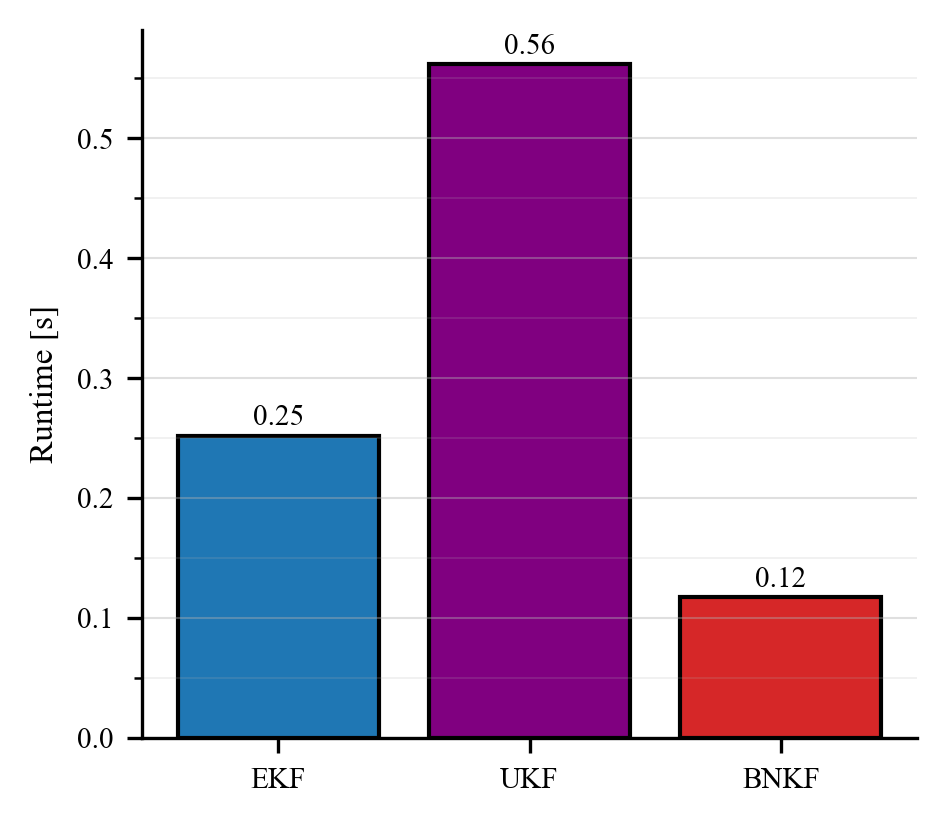

In [140]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

# Data
times  = [elapsed_ekf_time, elapsed_ukf_time, elapsed_bnkf_time]
labels = ["EKF", "UKF", "BNKF"]

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

# Match previous grayscale palette
colors = {
    "EKF":  "#1f77b4",  # blue
    "UKF":  "#800080",  # purple
    "BNKF": "#d62728",  # red
}

# Slightly smaller IEEE-friendly font sizes
mpl.rcParams.update({
    "font.size": 8,
    "axes.titlesize": 9,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "figure.dpi": 300
})

# Smaller figure size
fig, ax = plt.subplots(figsize=(3.0, 2.6))

# Narrower bars
bars = ax.bar(labels, times,
              width=0.8,
              color=[colors[l] for l in labels],
              edgecolor="black")

ax.set_ylabel("Runtime [s]", fontsize=8)

# Minor grid
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.grid(axis='y', which='major', linewidth=0.5, alpha=0.4)
ax.grid(axis='y', which='minor', linewidth=0.4, alpha=0.2)

# Clean spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Value labels, smaller font & tighter padding
ax.bar_label(bars, fmt="%.2f", padding=1, fontsize=7)

plt.tight_layout(pad=0.2)
plt.savefig("../../report/images/runtime_barplot.png", dpi=600, bbox_inches="tight")
# plt.savefig("../../report/images/runtime_barplot.pdf", bbox_inches="tight")
plt.show()
